In [65]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import tensorflow_probability as tfp

In [66]:
# name = 'PL=F' #platinum
name = 'GC=F' #gold
# name = 'SI=F' #silver
# name = 'HG=F' #copper
# name = 'PA=F' #paladium
# name = 'CL=F' #crude oil
# name = 'BZ=F' #brent crude oil
# name = 'NG=F' #natural gas


train_end_date = '2022-01-01'

name_ohlc_df = yf.download(name, start='2010-01-01', end=train_end_date)
name_ohlc_df = name_ohlc_df.reset_index()

data = {'date': name_ohlc_df.Date, 'close': name_ohlc_df.Close}
df = pd.DataFrame(data)
df.head()

[*********************100%***********************]  1 of 1 completed


,date,close
0,2010-01-04,1117.699951
1,2010-01-05,1118.099976
2,2010-01-06,1135.900024
3,2010-01-07,1133.099976
4,2010-01-08,1138.199951


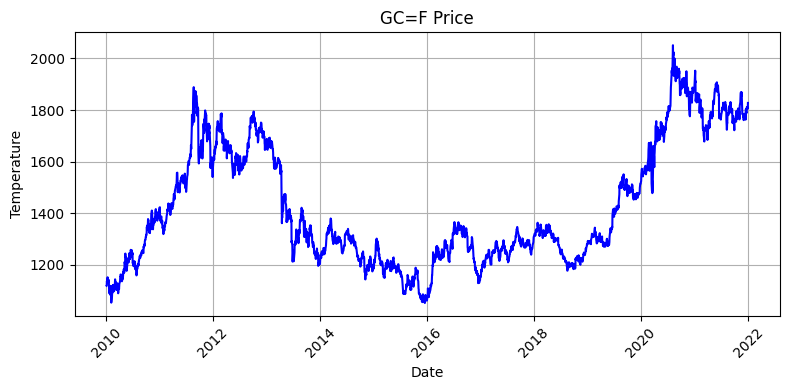

In [67]:
plt.figure(figsize=(8, 4))
plt.plot(df['date'], df['close'], linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title(name+' Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
# x1 = np.array(df.iloc[:,1]+np.random.randn(df.shape[0])).astype(np.float32).reshape(-1,1)
train_size = int(0.8 * len(df))

# x1 = np.array(df.iloc[:train_size,1]).astype(np.float32).reshape(-1,1)
sequence_length = 10
train_input = np.lib.stride_tricks.sliding_window_view(df.iloc[:train_size,1].values, sequence_length)
val_input = np.lib.stride_tricks.sliding_window_view(df.iloc[train_size:-1,1].values, sequence_length)

y1 = np.array(df.iloc[sequence_length:train_size+1,1]).T.astype(np.float32).reshape(-1,1)
y2 = np.array(df.iloc[sequence_length+train_size:,1]).T.astype(np.float32).reshape(-1,1)

tfd = tfp.distributions

In [69]:
# print(train_input[:2])
# print()
# print(y1[:2])
# print(train_input.shape,y1.shape)

print(val_input[:2])
print()
print(y2[:2])
print(val_input.shape,y2.shape)

[[1505.30004883 1502.19995117 1515.90002441 1519.59997559 1512.5
  1500.40002441 1504.59997559 1504.59997559 1497.30004883 1526.59997559]
 [1502.19995117 1515.90002441 1519.59997559 1512.5        1500.40002441
  1504.59997559 1504.59997559 1497.30004883 1526.59997559 1526.30004883]]

[[1526.3]
 [1541. ]]
(594, 10) (594, 1)


In [70]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])


In [71]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(32,activation='relu'),
  tfp.layers.DenseVariational(1 + 1 +1, posterior_mean_field, prior_trainable, kl_weight=1/train_input.shape[0]),
  tfp.layers.DistributionLambda(
      # lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
      lambda t: tfd.StudentT(df=10,loc=t[..., :1],scale=1e-3 + tf.math.softplus(t[...,1:2]))),
      # lambda t: tfd.TwoPieceStudentT(df=5,loc=t[..., :1],scale=1e-3 + 0.1*tf.math.softplus(t[...,1:2]),skewness=0.1 + 0.1*tf.math.softplus(t[...,2:]))),

])

In [72]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Do inference.
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.01), loss=negloglik)
model.fit(train_input, y1, epochs=1500, verbose=1);


Epoch 1/1500


76/76 [==============================] - 1s 711us/step - loss: 53.1369
Epoch 2/1500
76/76 [==============================] - 0s 659us/step - loss: 69.1452
Epoch 3/1500
76/76 [==============================] - 0s 619us/step - loss: 34.6143
Epoch 4/1500
76/76 [==============================] - 0s 598us/step - loss: 51.5148
Epoch 5/1500
76/76 [==============================] - 0s 630us/step - loss: 36.3993
Epoch 6/1500
76/76 [==============================] - 0s 557us/step - loss: 28.6161
Epoch 7/1500
76/76 [==============================] - 0s 529us/step - loss: 18.1437
Epoch 8/1500
76/76 [==============================] - 0s 585us/step - loss: 25.6318
Epoch 9/1500
76/76 [==============================] - 0s 972us/step - loss: 23.4747
Epoch 10/1500
76/76 [==============================] - 0s 543us/step - loss: 35.3539
Epoch 11/1500
76/76 [==============================] - 0s 596us/step - loss: 24.0496
Epoch 12/1500
76/76 [==============================] - 0s 588us/step - loss: 20.2169
Ep

In [73]:
# Profit.
yhat = model(val_input)
# [print(np.squeeze(w.numpy())) for w in model.weights];
assert isinstance(yhat, tfd.Distribution)

In [74]:
yhats = [model(val_input) for _ in range(100)]
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())

(594, 1) (594,) (594,)


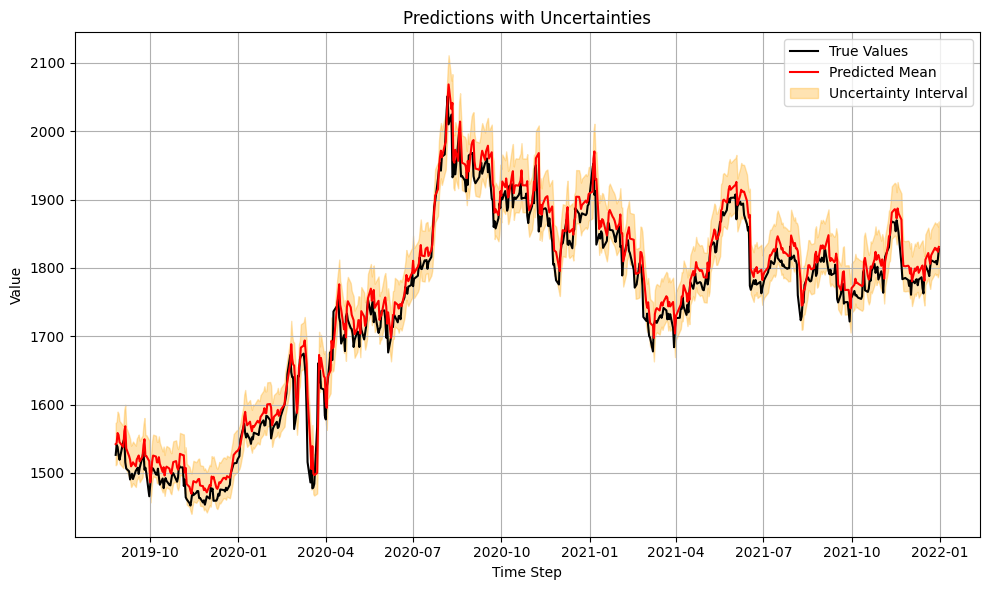

In [93]:
val_dates = np.array(df.iloc[sequence_length+train_size:,0]).T.reshape(-1,1)
print(val_dates.shape,y2.shape,m.shape)
upper_bound = m + s
lower_bound = m - s

plt.figure(figsize=(10, 6))
plt.plot(val_dates,y2, label='True Values', color='black')
plt.plot(val_dates,m, label='Predicted Mean', color='red')
plt.fill_between(val_dates.reshape(-1), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions with Uncertainties')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.xlim((val_dates[50][0],val_dates[350][0]))
plt.show()

(40, 10) (40, 1) (40, 1) (40,)


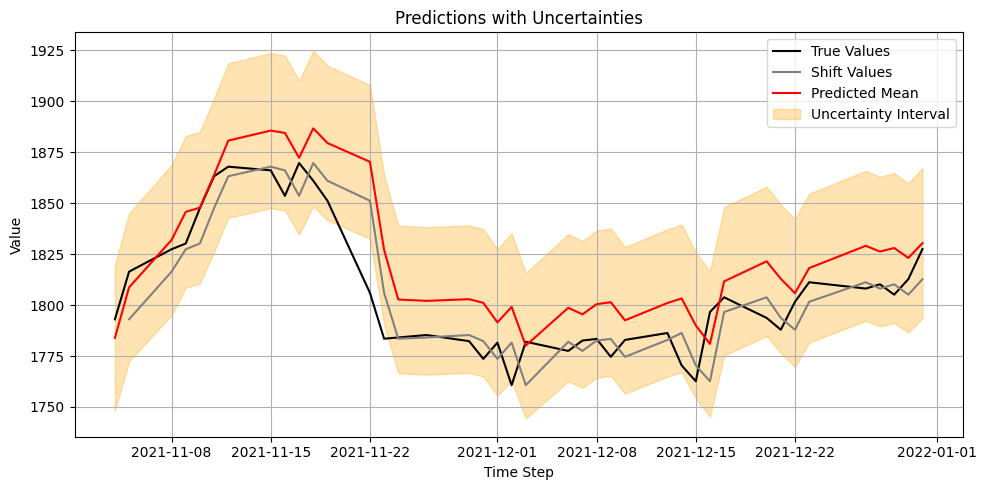

In [76]:
test_size = -50
test_input = np.lib.stride_tricks.sliding_window_view(df.iloc[test_size:-1,1].values, sequence_length)
y3 = np.array(df.iloc[sequence_length+test_size:,1]).T.astype(np.float32).reshape(-1,1)
y3shift = np.roll(y3, shift=1)
y3shift[0] = np.nan
test_dates = np.array(df.iloc[sequence_length+test_size:,0]).T.reshape(-1,1)

yhats_test = [model(test_input) for _ in range(100)]

for i, yhat in enumerate(yhats_test):
  m_test = np.squeeze(yhat.mean())
  s_test = np.squeeze(yhat.stddev())

print(test_input.shape,y3.shape,test_dates.shape,m_test.shape)
upper_bound = m_test + s_test
lower_bound = m_test - s_test

plt.figure(figsize=(10,5))
plt.plot(test_dates, y3, label='True Values', color='black')
plt.plot(test_dates, y3shift, label='Shift Values', color='grey')
plt.plot(test_dates, m_test, label='Predicted Mean', color='red')
plt.fill_between(test_dates.reshape(-1), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions with Uncertainties')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_mape(true_data, forecast_data):
    absolute_percentage_errors = np.abs((true_data - forecast_data) / true_data)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

def calculate_rmse(true_data, forecast_data):
    rmse = np.sqrt(mean_squared_error(true_data, forecast_data))
    return rmse

def calculate_mae(true_data, forecast_data):
    mae = mean_absolute_error(true_data, forecast_data)
    return mae

def calculate_r2(true_data, forecast_data):
    r2 = r2_score(true_data, forecast_data)
    return r2

def calculate_forecast_bias(true_data, forecast_data):
    forecast_bias = np.mean(forecast_data - true_data)
    return forecast_bias


mape = calculate_mape(y3, m_test)
rmse = calculate_rmse(y3, m_test)
mae = calculate_mae(y3, m_test)
fb = calculate_forecast_bias(y3, m_test)
r2 = calculate_r2(y3, m_test)
print("MAPE:", mape,'\nRMSE:',rmse,'\nMAE:',mae,'\nFB:',fb,'\nR2:',r2)
print()
mape = calculate_mape(y3, np.nan_to_num(y3shift,nan=0.0))
rmse = calculate_rmse(y3, np.nan_to_num(y3shift,nan=0.0))
mae = calculate_mae(y3, np.nan_to_num(y3shift,nan=0.0))
fb = calculate_forecast_bias(y3, np.nan_to_num(y3shift,nan=0.0))
r2 = calculate_r2(y3, np.nan_to_num(y3shift,nan=0.0))
print("MAPE:", mape,'\nRMSE:',rmse,'\nMAE:',mae,'\nFB:',fb,'\nR2:',r2)

MAPE: 2.0965760573744774 
RMSE: 22.16474 
MAE: 18.050009 
FB: 16.331764 
R2: 0.5021198984186118

MAPE: 3.0850809067487717 
RMSE: 283.8456 
MAE: 55.39751 
FB: -45.6875 
R2: -80.6514280237626


In [78]:
print(list(y3))
print(m_test)

[array([1793.], dtype=float32), array([1816.4], dtype=float32), array([1827.4], dtype=float32), array([1830.2], dtype=float32), array([1847.6], dtype=float32), array([1863.2], dtype=float32), array([1867.9], dtype=float32), array([1866.1], dtype=float32), array([1853.6], dtype=float32), array([1869.7], dtype=float32), array([1861.], dtype=float32), array([1851.2], dtype=float32), array([1806.], dtype=float32), array([1783.5], dtype=float32), array([1784.1], dtype=float32), array([1785.3], dtype=float32), array([1782.3], dtype=float32), array([1773.6], dtype=float32), array([1781.6], dtype=float32), array([1760.7], dtype=float32), array([1782.], dtype=float32), array([1777.5], dtype=float32), array([1782.6], dtype=float32), array([1783.4], dtype=float32), array([1774.6], dtype=float32), array([1782.9], dtype=float32), array([1786.3], dtype=float32), array([1770.4], dtype=float32), array([1762.6], dtype=float32), array([1796.6], dtype=float32), array([1803.8], dtype=float32), array([1793

(594,) (594,)
(594,)
(593,)
(594,)


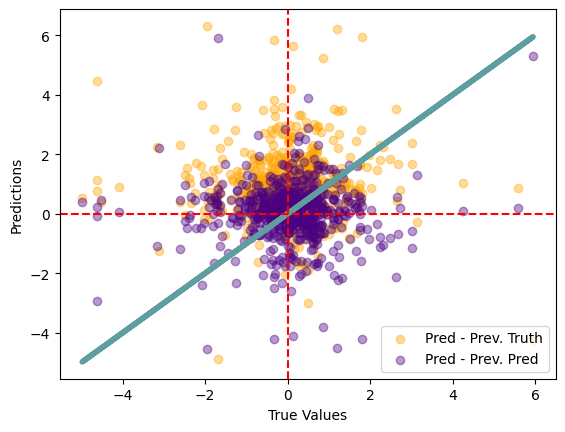

In [79]:
y2 = y2.reshape(-1)
print(y2.shape,m.shape)
print(m.shape)
true_pct_changes = (np.diff(y2) / y2[:-1]) * 100
pred_pct_changes = ((m - y2) / y2) * 100 
pred_pct_changes2 = (np.diff(m) / m[:-1]) * 100

# y3 = y3.reshape(-1)
# true_pct_changes = (np.diff(y3) / y3[:-1]) * 100
# pred_pct_changes = ((m_test - y3) / y3) * 100 


print(true_pct_changes.shape)
print(pred_pct_changes.shape)
plt.figure()
plt.scatter(true_pct_changes, pred_pct_changes[:-1],color='orange',alpha=.4,label='Pred - Prev. Truth')
plt.scatter(true_pct_changes, pred_pct_changes2,color='indigo',alpha=.4,label='Pred - Prev. Pred')
plt.plot(true_pct_changes, true_pct_changes,lw=4,color='cadetblue')
plt.axhline(y=0,ls='--',color='red')
plt.axvline(x=0,ls='--',color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

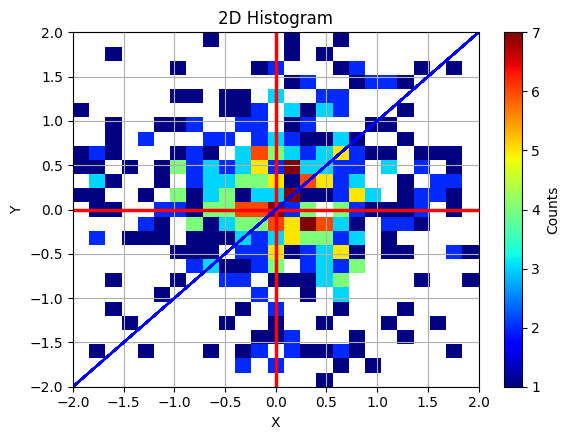

In [80]:
plt.figure(figsize=(6, 4.5))
# plt.hist2d(true_pct_changes, pred_pct_changes[:-1], bins=25, cmap='jet',range=[[-2, 2], [-2, 2]],cmin=1)
plt.hist2d(true_pct_changes, pred_pct_changes2, bins=25, cmap='jet',range=[[-2, 2], [-2, 2]],cmin=1)
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram')
plt.axhline(y=0, color='red', linestyle='-',lw=2.5)   # Horizontal line at y=0
plt.axvline(x=0, color='red', linestyle='-',lw=2.5)  # Vertical line at x=0
plt.plot(true_pct_changes, true_pct_changes, color='blue')   
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(np.sign(true_pct_changes), np.sign(pred_pct_changes[:-1]), labels=[1, -1])
# conf_matrix = confusion_matrix(np.sign(true_pct_changes), np.sign(pred_pct_changes2), labels=[1, -1])
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[173 144]
 [149 121]]


In [18]:
#one day test
one_day_input = np.lib.stride_tricks.sliding_window_view(df.iloc[-12:,1].values, sequence_length)[:-1]
y4 = np.array(df.iloc[sequence_length-12:,1]).astype(np.float32)


print(one_day_input)
print(y4)

[[1549.40002441 1720.59997559 1782.59997559 1743.69995117 1790.90002441
  1887.09997559 1954.69995117 1944.30004883 1998.40002441 1984.80004883]
 [1720.59997559 1782.59997559 1743.69995117 1790.90002441 1887.09997559
  1954.69995117 1944.30004883 1998.40002441 1984.80004883 1979.19995117]]
[1979.2 1908.1]


In [19]:
#aleatoric uncertainty +- sigma
#epistemic uncertainty 100 predict calls
yhats_test = [model(one_day_input) for _ in range(100)]

means = []
stds = []
avgm = np.zeros_like(one_day_input[...,0])
for i, yhat in enumerate(yhats_test):
  means.append(yhat.mean())
  stds.append(yhat.stddev())
  m_test = np.squeeze(yhat.mean())
  s_test = np.squeeze(yhat.stddev())
  avgm += m_test/len(yhats_test)

mean_array = np.mean(np.array(means),axis=0)
std_array = np.mean(np.array(stds),axis=0)
print(mean_array)
print(std_array)
print(avgm)
# print(means)
print('Pred: ',m_test,'+-',s_test)
upper_bound = m_test + s_test
lower_bound = m_test - s_test
# print(m_test, '+-', s_test)
print('Truth: ',y4)

[[1990.3939]
 [1989.9235]]
[[37.779884]
 [37.772064]]
[1990.39377213 1989.92357254]
Pred:  [1990.309  1989.8386] +- [37.38881  37.381096]
Truth:  [1979.2 1908.1]


In [64]:
# import matplotlib
# yhats_test = [model(one_day_input) for _ in range(100)]
# means = []
# stds = []
# for i, yhat in enumerate(yhats_test):
#   means.append(yhat.mean())
#   stds.append(yhat.stddev())

# # print(means)
# # print(y4)
# one_day_dates = np.array(df.iloc[sequence_length-12:,0]).T.reshape(-1,1)
# violin_data = np.array(means).reshape((len(yhats_test),yhats_test[0].shape[0]))
# print(one_day_dates.shape)
# print(violin_data.shape)
# #violin plot again
# fig, ax = plt.subplots(figsize=(12,5))
# # ax.scatter(matplotlib.dates.date2num(one_day_dates), y4,color='green',label='Truth')
# violin = ax.violinplot(violin_data,positions=matplotlib.dates.date2num(one_day_dates),showmeans=True,showmedians=True)
# for pc in violin["bodies"]:
#     pc.set_facecolor("orange")
#     pc.set_edgecolor("black")
#     pc.set_alpha(0.3)
# ax.tick_params(axis='x', rotation=45)